<a href="https://colab.research.google.com/github/duncansnh/burn-mapping/blob/region_growing/CUU_burn_extent_image_thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Script to threshold an input image based on one or more index thresholds
Inputs are

1)  indices generated from sentinel 2 imagery (generated from previous script)
2)  pickled object containing training data to define thresholds 

Main steps:
•	threshold the image

Duncan Blake NatureScot 30 September 2020

Changes 13 November 2020: 

Extra code to create a second thresholding layer to test whether this is a viable alternative to region growing.
Code also converts core and extended burn areas to polygon, joins them spatially and exports final expanded burn areas as a shapefile.

## Install and import required libraries

In [ ]:
# raster libraries
! pip install rasterio
! pip install rasterstats


In [ ]:
# Vector libraries
# This code takes a while but ensures dependencies for geopandas are installed for Colabs, may not be required in other environments.
# Taken from shakasom's post at https://github.com/geopandas/geopandas/issues/901
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import geopandas as gpd
import descartes
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
from rasterio.features import sieve, shapes
from shapely.geometry import mapping, shape
from rasterstats import zonal_stats
import gdal
import pprint


/usr/local/lib/python3.6/dist-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


## Mount Google Drive

In [5]:
#Only if running in Google Colab, in which case input image and output results need to be in Google Drive.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Set working drive, file paths and dataset name parameters


In [6]:

wd = '/content/drive/My Drive'
image_dir = os.path.join(wd, 'Imagery')
plot_dir = os.path.join(wd, 'Plots')

# Cairngorms parameters
# input tif image with indices
# image = 'CUU_burn_cairngorms_indices.tif'
# outImage = 'CUU_burn_cairngorms_core_burns.tif' #optional
#Final output shapefile
#outPoly = 'CUU_burn_cairngorms_burns_poly.shp'

# Skye parameters
image = 'CUU_burn_skye_indices.tif'
# outImage = 'CUU_burn_skye_core_burns.tif'
#Final output shapefile
outPoly = 'CUU_burn_skye_burns_poly2.shp'

## Open input image and polygon dataset

In [7]:
# Read image
s2 = rasterio.open(os.path.join(image_dir,image))
print(s2.shape)
profile = s2.profile.copy()
# optionally check all ok by showing dsavi layer
#plt.imshow(s2.read(21), cmap='pink')
print(s2.crs)

(5850, 5263)
PROJCS["British_National_Grid",GEOGCS["GCS_OSGB_1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000043,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


## Import pickled dataframe and determine threshold values from percentiles


In [8]:
# read in pickled object of all data combined (created from previous script that generated the boxplots)
pickleName = ("All_data_for_thresholding.pkl")
df_all_data = pd.read_pickle(os.path.join(plot_dir,pickleName))

# obtain percentile values
# isolate burn rows in dataframe
df_burns = df_all_data[df_all_data.Class == "Burns"]
# subset columns we are interested in
df_burns_indices = df_burns[['dnbr','dnbr2','dcsi','dsavi','postnbr']]
# extract quartile statistics needed

# medians
print("medians")
dNBRQ2 = df_burns_indices.dnbr.quantile(0.5)
print(dNBRQ2)
dSAVIQ2 = df_burns_indices.dsavi.quantile(0.5)
print(dSAVIQ2)
postNBRQ2 = df_burns_indices.postnbr.quantile(0.5)
print(postNBRQ2)

# 75th percentile
print("75th percentiles")
dNBRQ3 = df_burns_indices.dnbr.quantile(0.75)
print(dNBRQ3)
dSAVIQ3 = df_burns_indices.dsavi.quantile(0.75)
print(dSAVIQ3)
postNBRQ3 = df_burns_indices.postnbr.quantile(0.75)
print(postNBRQ3)
dNBR2Q3 = df_burns_indices.dnbr2.quantile(0.75)
print(dNBR2Q3)

# 25th percentile for extended areas
print("25th percentiles")
dSAVIQ1 = df_burns_indices.dsavi.quantile(0.25)
print(dSAVIQ1)
postNBRQ1 = df_burns_indices.postnbr.quantile(0.25)
print(postNBRQ1)

medians
0.214064359664917
0.2852725386619568
0.23950617015361786
75th percentiles
0.2735748812556267
0.3618958219885826
0.2981530427932739
0.1445029228925705
25th percentiles
0.20674878358840942
0.17344753444194794


## Set the threshold


In [9]:
# for multiple indices threshold
# read in bands required 2 postnbr; 3 dnbr; 6 dnbr2; 15 dcsi; 21 dsavi 
indicesArray = s2.read([2,3,6,15,21])

# read in a single band as a template for the output reclassified image containing core burn pixels
band1 = s2.read(1)
reclassArray = band1.copy()
# reset all values in output raster to 0 as otherwise pixel values not reclassed by the condition below may retain value from prenbr (band1)
reclassArray[np.where(reclassArray != 0)] = 0

# set up second array to hold extended burn area
extendArray = np.copy(reclassArray)

# reclassify the array to contain core burn pixels
# in this case where dsavi is greater than the median and post fire image NBR is greater than the median 
reclassArray[np.where((indicesArray[4]>=dSAVIQ2) & (indicesArray[0]>=postNBRQ2))] = 1 
# then attempt to solve issue of edges of clouds being falsely identified which have high values in dnbr2
reclassArray[np.where(indicesArray[2]>=0.8)] = 0

# rasterio function to exclude clumps of pixels smaller than 3.  Diagonally joined pixels are allowed.
sievedArray = sieve(reclassArray.astype(rasterio.uint8), size=3, connectivity=8)

# reclassify the second array to contain extended burn pixels
extendArray[np.where((indicesArray[4]>=dSAVIQ1) & (indicesArray[0]>=postNBRQ1))] = 1 
# then attempt to solve issue of edges of clouds being falsely identified which have high values in dnbr2
extendArray[np.where(indicesArray[2]>=0.8)] = 0

# rasterio function to exclude clumps of pixels smaller than 3.  Diagonally joined pixels are allowed.
sievedExtendArray = sieve(extendArray.astype(rasterio.uint8), size=3, connectivity=8)

## Plot the thresholded rasters

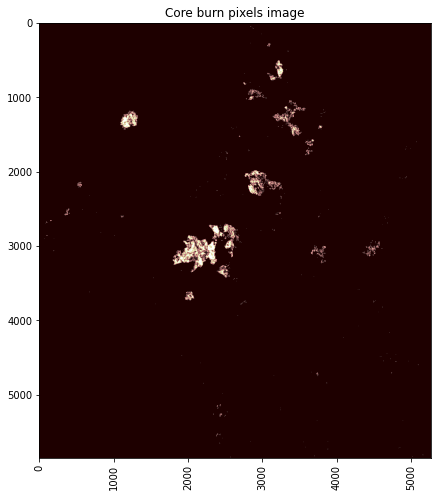

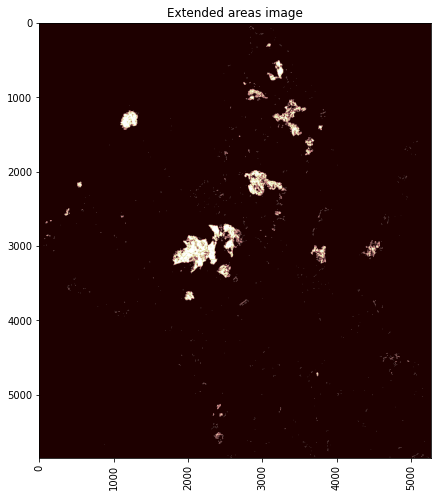

In [10]:
# an inital look to see if in the right ballpark but viewing in GIS is much better!
plt.figure(figsize=(10,8)); 
plt.imshow(sievedArray,cmap='pink')
plt.title('Core burn pixels image')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

plt.figure(figsize=(10,8)); 
plt.imshow(sievedExtendArray,cmap='pink')
plt.title('Extended areas image')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees


## Create shapes from the two rasters

epsg:27700
<bound method DataFrame.info of                                                geometry  raster_val
0     POLYGON ((140820.000 877060.000, 140820.000 87...         1.0
1     POLYGON ((140810.000 877050.000, 140810.000 87...         1.0
2     POLYGON ((140790.000 877060.000, 140790.000 87...         1.0
3     POLYGON ((141070.000 876860.000, 141070.000 87...         1.0
4     POLYGON ((141060.000 876840.000, 141060.000 87...         1.0
...                                                 ...         ...
5643  POLYGON ((149310.000 819300.000, 149310.000 81...         1.0
5644  POLYGON ((162510.000 819230.000, 162510.000 81...         1.0
5645  POLYGON ((162500.000 819220.000, 162500.000 81...         1.0
5646  POLYGON ((138080.000 819160.000, 138080.000 81...         1.0
5647  POLYGON ((112370.000 877510.000, 112370.000 81...         0.0

[5648 rows x 2 columns]>
epsg:27700
<bound method DataFrame.info of                                                geometry  raster_val
0   

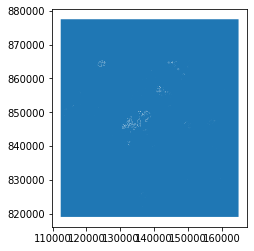

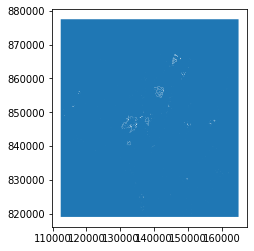

In [12]:
# code adapted from https://github.com/mapbox/rasterio/blob/fb93a6425c17f25141ad308cee7263d0c491a0a9/examples/rasterio_polygonize.py

# create shapes from numpy array (IMPORTANT: the transform argument from the original image is essential otherwise 
# image coordinates rather than BNG coordinates are used for the features )
# NB 'shapes' from rasterio' creates geoJSON generator objects
# TODO would be better written as a function

coreShapes = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(
                shapes(sievedArray, transform=s2.transform)))

coreShapesGeoms = list(coreShapes)
# convert geoJSON objects to a geopandas data frame
gpd_coreShapes  = gpd.GeoDataFrame.from_features(coreShapesGeoms)

# it has no projection though so this is defined
gpd_coreShapes = gpd_coreShapes.set_crs(epsg=27700)

# check it looks ok and crs has been set
gpd_coreShapes.plot()
print(gpd_coreShapes.crs)
print(gpd_coreShapes.info)

#### now do the same for extended burn areas ####
extendShapes = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(
                shapes(sievedExtendArray, transform=s2.transform)))

extendShapesGeoms = list(extendShapes)
# convert geoJSON objects to a geopandas data frame
gpd_extendShapes  = gpd.GeoDataFrame.from_features(extendShapesGeoms)

# it has no projection though so this is defined
gpd_extendShapes = gpd_extendShapes.set_crs(epsg=27700)

# check it looks ok and crs has been set
gpd_extendShapes.plot()
print(gpd_extendShapes.crs)
print(gpd_extendShapes.info)

## Use spatial join to detect polygons in extended burn areas that intersect core burn pixels

<bound method DataFrame.info of                                                geometry
0     POLYGON ((140800.000 877070.000, 140800.000 87...
2     POLYGON ((140790.000 877060.000, 140790.000 87...
1     POLYGON ((140820.000 877070.000, 140820.000 87...
7     POLYGON ((141070.000 876870.000, 141070.000 87...
11    POLYGON ((141100.000 876790.000, 141100.000 87...
...                                                 ...
3936  POLYGON ((163850.000 819410.000, 163850.000 81...
3933  POLYGON ((163960.000 819440.000, 163960.000 81...
3946  POLYGON ((149310.000 819300.000, 149310.000 81...
3959  POLYGON ((162520.000 819240.000, 162520.000 81...
3964  POLYGON ((138080.000 819160.000, 138080.000 81...

[556 rows x 1 columns]>


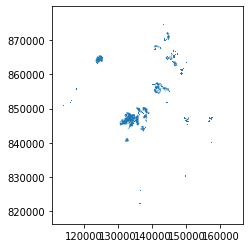

In [37]:
# subset the geodataframes to only include rows that are burns
gpd_coreBurnShapes = gpd_coreShapes[gpd_coreShapes["raster_val"] == 1.0]
gpd_extendBurnShapes = gpd_extendShapes[gpd_extendShapes["raster_val"] == 1.0]

# indexing needs to be reset to enable spatial join to work properly
gpd_coreBurnShapes = gpd_coreBurnShapes.reset_index(drop=True)
gpd_extendBurnShapes = gpd_extendBurnShapes.reset_index(drop=True)
print(gpd_coreBurnShapes.info)

# carry out spatial join
gpd_spatialJoin = gpd.sjoin(gpd_extendBurnShapes, gpd_coreBurnShapes, how="inner", op='intersects')
# get rid of attribute columns which are not required
gpd_spatialJoin = gpd_spatialJoin.drop(columns=['index_right','raster_val_left','raster_val_right'])
# drop duplicate geometries
gpd_finalShapes = gpd_spatialJoin.drop_duplicates(subset = 'geometry', keep = 'first')

gpd_finalShapes.plot()
print(gpd_finalShapes.info)

## Export outputs

In [38]:
# export to shapefile
gpd_finalShapes.to_file(os.path.join(image_dir, outPoly), driver='ESRI Shapefile')

# optional export the classified array, converting to an integer
# profile.update(dtype=rasterio.uint8,
#         count=1,
#         compress='lzw')  

# with rasterio.open(os.path.join(image_dir,outImage), 'w', **profile) as dst:
#         dst.write(sievedArray, 1)